# WIDS Predict Hospital Fatality

**Table of Contents:**

1. Import Libriaries/packages
2. Explore Data
3. Preprocess data (missing values, collinearity (correlation), scale)
4. Model http://localhost:8888/lab#Convert-to-numerical-via-labelencoding-or-onehotencoding-#revisit
5. Evaluate


In [1]:
from datetime import datetime

# track start time
start_time = datetime.now()

In [2]:
# view input directory

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./input\samplesubmission.csv
./input\solution_template.csv
./input\training_v2.csv
./input\unlabeled.csv
./input\WiDS Datathon 2020 Dictionary.csv


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import SimpleImputer
import seaborn as sns # plotting library
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder



# additional experiement packages
import missingno as msno

%matplotlib inline

## Load Data

In [43]:
# loading dataset 

training = pd.read_csv("./input/training_v2.csv")
solution_template = pd.read_csv("./input/solution_template.csv")
samplesubmission = pd.read_csv("./input/samplesubmission.csv")

In [43]:
unlabeled = pd.read_csv("./input/unlabeled.csv")

In [43]:
dictionary = pd.read_csv("./input/WiDS Datathon 2020 Dictionary.csv")

In [5]:
# create a back up

training_backup = training.copy()

In [6]:
# view data

training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


In [7]:
solution_template.head()

,encounter_id,hospital_death
0,2,NaN
1,5,NaN
2,7,NaN
3,8,NaN
4,10,NaN


In [8]:
samplesubmission.head()

,encounter_id,hospital_death
0,2,0.500
1,5,0.200
2,7,0.001


In [9]:
unlabeled.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,127112,7,NaN,56.0,21.102439,0,Caucasian,M,180.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
1,5,130737,178,NaN,NaN,19.500595,1,Caucasian,F,145.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
2,7,101458,86,NaN,66.0,32.518596,1,African American,M,170.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
3,8,48067,163,NaN,64.0,20.798520,0,Caucasian,M,182.8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Respiratory,Respiratory
4,10,25865,59,NaN,56.0,NaN,0,Caucasian,M,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


In [10]:
unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39308 entries, 0 to 39307
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(171), int64(7), object(8)
memory usage: 55.8+ MB


In [11]:
dictionary.head()

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient un...,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None
2,identifier,patient_id,None,integer,Unique identifier associated with a patient,None
3,demographic,hospital_death,None,binary,Whether the patient died during this hospitali...,0
4,demographic,age,Years,numeric,The age of the patient on unit admission,None


## Explore Data:

1. One way plots (bar and dot plot) (recommedation from Emily L)

In [12]:
training.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [13]:
x, y, hue = "index", "hospital_death", "sex"
hue_order = ["Male", "Female"]

(training.gender
 .value_counts(normalize=True)
 .rename({'gender': 'proportion'}, axis=0)
 )

M    0.539536
F    0.460464
Name: gender, dtype: float64

In [14]:
training['gender_missing'] = training.gender.copy()

In [15]:
training['gender_missing'] = training.gender_missing.fillna('Missing')

In [16]:
training.gender_missing.value_counts()

M          49469
F          42219
Missing       25
Name: gender_missing, dtype: int64

In [17]:
training['gender_missing'].value_counts(normalize=True)

M          0.539389
F          0.460338
Missing    0.000273
Name: gender_missing, dtype: float64

In [18]:
training.groupby('gender_missing').mean()['hospital_death']

gender_missing
F          0.088373
M          0.084417
Missing    0.320000
Name: hospital_death, dtype: float64

In [19]:
training.groupby('gender').mean()['hospital_death']

gender
F    0.088373
M    0.084417
Name: hospital_death, dtype: float64

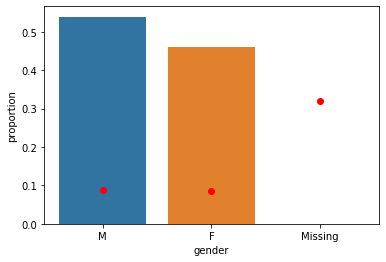

In [20]:
(training['gender_missing']
.value_counts(normalize=True)
.reset_index()
.rename(columns={'index': 'gender', 'gender_missing': 'proportion'})
.pipe((sns.barplot, 'data'), x='gender', y='proportion')
)

plt.plot(training.groupby('gender_missing').mean()['hospital_death'], 'ro')



### Calculate correlation matrix

In [21]:
%%time

corr_matrix = training.corr().abs

Wall time: 7.21 s


In [22]:
training_3 = training.copy()

In [23]:
training_3.drop(training_3.columns[training_3.apply(lambda col: col.isnull().sum() / training_3.shape[0] > 0.5)], axis = 1)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gender_missing
0,66154,25312,118,0,68.0,22.730000,0,Caucasian,M,180.3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,M
1,114252,59342,81,0,77.0,27.420000,0,Caucasian,F,160.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,F
2,119783,50777,118,0,25.0,31.950000,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,F
3,79267,46918,118,0,81.0,22.640000,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,F
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,0,75.0,23.060250,0,Caucasian,M,177.8,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular,M
91709,66119,13486,121,0,56.0,47.179671,0,Caucasian,F,183.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,F
91710,8981,58179,195,0,48.0,27.236914,0,Caucasian,M,170.2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,M
91711,33776,120598,66,0,NaN,23.297481,0,Caucasian,F,154.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,F


In [24]:
training.dtypes.value_counts()

float64    170
object       9
int64        8
dtype: int64

In [25]:
training['patient_id'].nunique()

91713

In [26]:
training['age'].describe()

count    87485.000000
mean        62.309516
std         16.775119
min         16.000000
25%         52.000000
50%         65.000000
75%         75.000000
max         89.000000
Name: age, dtype: float64

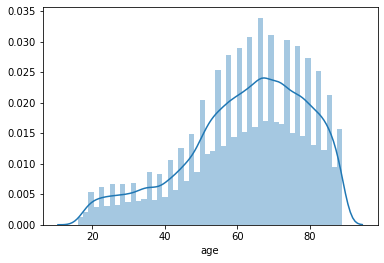

In [27]:
sns.distplot(training['age'].dropna())

## Drop useless fields

In [28]:
#drop these columns

id_columns_to_drop = training.filter(regex='id$',axis=1).columns

In [29]:
training.drop(columns=id_columns_to_drop, inplace=True)

In [30]:
def drop_id_fields(df):
    id_columns_to_drop = df.filter(regex='id$',axis=1).columns
    df.drop(columns=id_columns_to_drop, inplace=True)
    return df

## Missing values

3 Types of Missing values:

1. MCAR Missing completely at random
    - This is generally ok to impute mean, mode or median.
    
The two below must be treated with caution. When there is a dependance with the target and other variables with why it is missing then there may be an improvement if a model is used to impute the missing values.

2. MAR Missing at random
3. MNAR Missing not at random

Columnwise

Text(0, 0.5, 'count of fields')

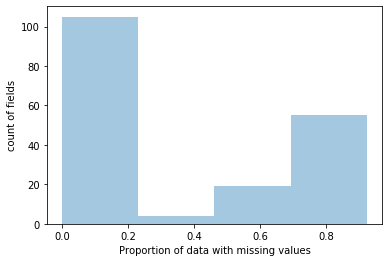

In [31]:
sns.distplot((training.isnull().sum()/training.shape[0]).sort_values(ascending=False), kde=False)

plt.xlabel('Proportion of data with missing values')
plt.ylabel('count of fields')

Text(0, 0.5, 'count of fields')

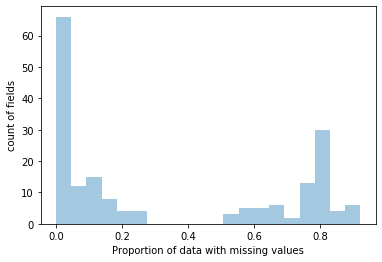

In [32]:
sns.distplot((training.isnull().sum()/training.shape[0]).sort_values(ascending=False), kde=False, bins=20
            )

plt.xlabel('Proportion of data with missing values')
plt.ylabel('count of fields')

Based on the plot below, we have decided to make the cut off for missing values at 40%

In [33]:
list_to_drop = training.columns[(training.isnull().sum()/training.shape[0])>0.1]

In [34]:
training.drop(columns=list_to_drop, inplace=True)

In [35]:
def drop_missing_columns(df):
    list_to_drop = df.columns[(df.isnull().sum()/df.shape[0])>0.1]
    df.drop(columns=list_to_drop, inplace=True)
    return df

In [36]:
training.head()

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_stay_type,icu_type,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gender_missing
0,0,68.0,22.73,0,Caucasian,M,180.3,Floor,admit,CTICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,M
1,0,77.0,27.42,0,Caucasian,F,160.0,Floor,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,F
2,0,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,F
3,0,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,admit,CTICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,F
4,0,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,M


Missing values Row-wise

Text(0, 0.5, 'count of rows')

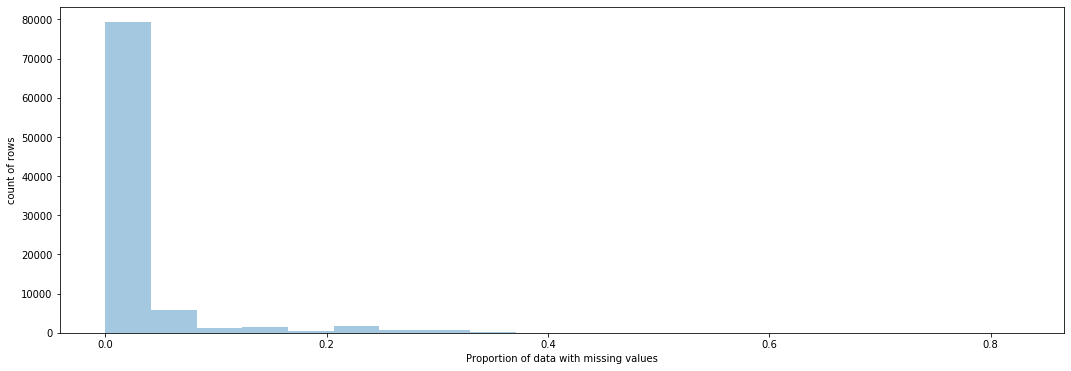

In [37]:
plt.figure(figsize=(18,6))

sns.distplot((training.isnull().sum(axis=1)/training.shape[1]).sort_values(ascending=False), kde=False, bins=20
            )

plt.xlabel('Proportion of data with missing values')
plt.ylabel('count of rows')

In [38]:
training[(training.isnull().sum(axis=1)/training.shape[1])>0.1]

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,icu_stay_type,icu_type,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gender_missing
4,0,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,M
19,0,39.0,37.010278,1,NaN,M,177.8,Operating Room / Recovery,admit,CTICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,M
46,1,64.0,16.980389,0,Caucasian,M,180.3,Operating Room / Recovery,admit,Neuro ICU,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,Neurological,Neurologic,M
51,0,53.0,NaN,1,Caucasian,F,162.6,Operating Room / Recovery,admit,CTICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Undefined diagnoses,F
52,0,73.0,28.058219,1,Caucasian,M,177.8,Operating Room / Recovery,admit,CTICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91704,0,38.0,32.992923,0,Caucasian,M,177.8,Accident & Emergency,admit,Cardiac ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,M
91705,0,67.0,28.876843,0,African American,M,182.9,Accident & Emergency,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,M
91707,0,NaN,33.933518,0,Caucasian,F,152.0,Accident & Emergency,admit,Med-Surg ICU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F
91710,0,48.0,27.236914,0,Caucasian,M,170.2,Accident & Emergency,admit,Med-Surg ICU,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,M


In [39]:
rows_to_drop = training[(training.isnull().sum(axis=1)/training.shape[1])>0.2].index

In [40]:
training.drop(rows_to_drop, inplace=True)

In [41]:
def drop_missing_rows(df):
    rows_to_drop = df[(df.isnull().sum(axis=1)/df.shape[1])>0.2].index
    df.drop(rows_to_drop, inplace=True)
    return df

In [42]:
import missingno as msno

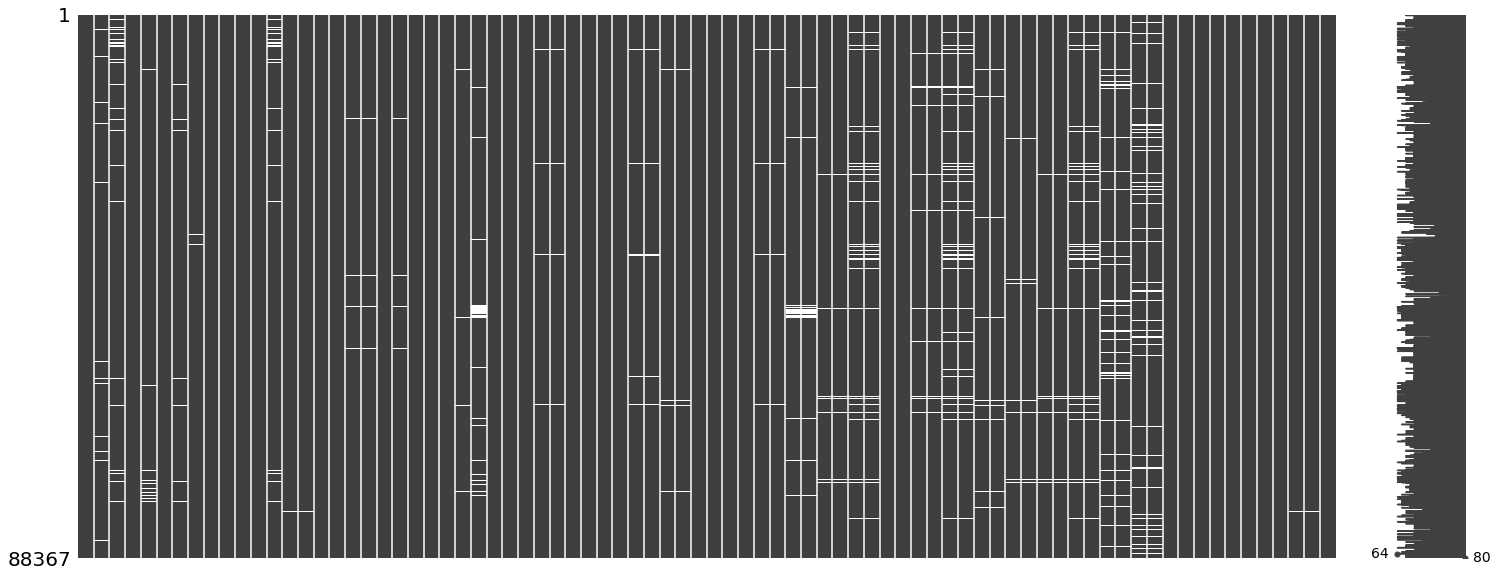

In [43]:
msno.matrix(training)

In [44]:
categorical = training.select_dtypes('object')

In [45]:
numerical = training.select_dtypes(exclude='object')

## fill nas

In [46]:
training.dtypes.value_counts()

float64    68
object      8
int64       4
dtype: int64

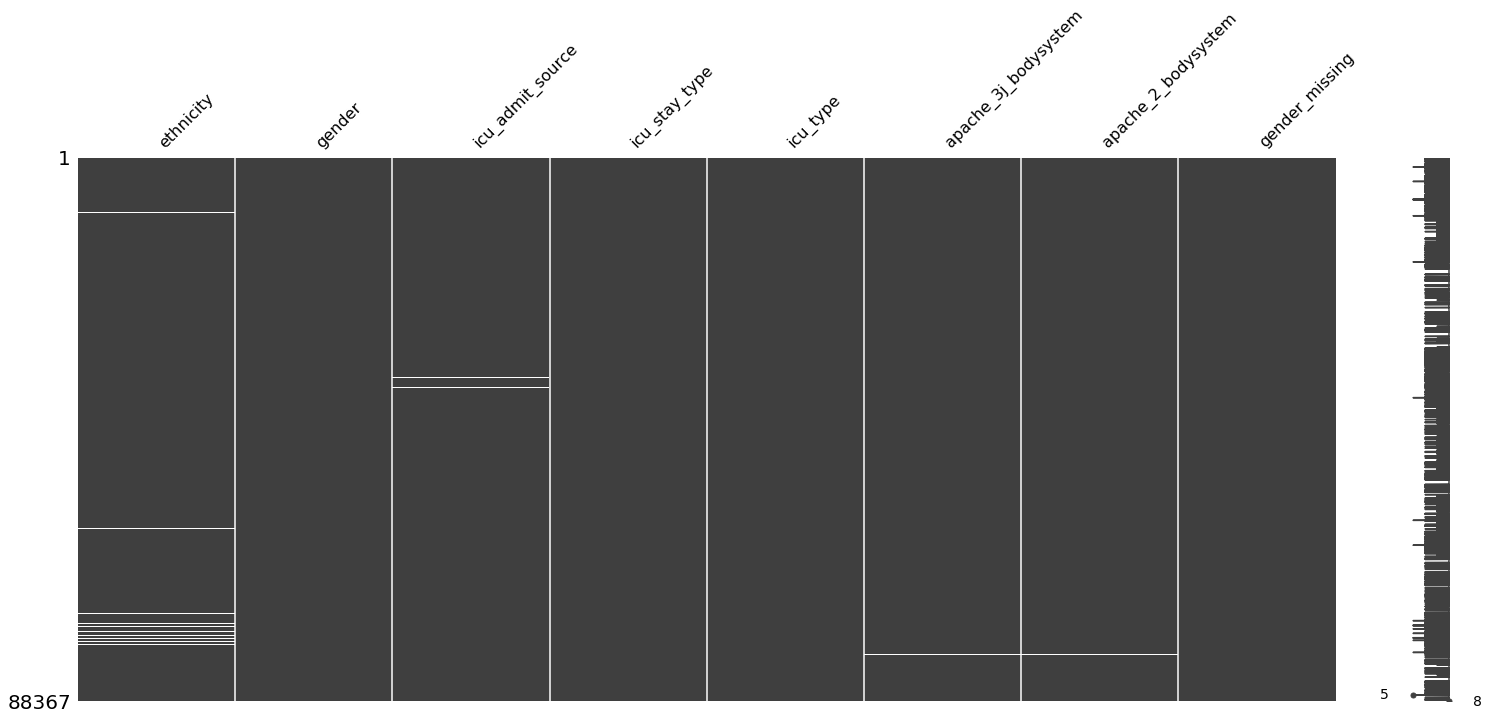

In [47]:
msno.matrix(categorical)

In [48]:
categorical.isnull().sum()

ethnicity               1255
gender                    23
icu_admit_source          95
icu_stay_type              0
icu_type                   0
apache_3j_bodysystem     821
apache_2_bodysystem      821
gender_missing             0
dtype: int64

In [49]:
from sklearn.impute import SimpleImputer

## categorical imputer

cat_imp = SimpleImputer(strategy="most_frequent")

In [50]:
training_backup = training.copy()

In [51]:
training[categorical.columns] = cat_imp.fit_transform(categorical)

In [52]:
training[categorical.columns].isnull().sum()

ethnicity               0
gender                  0
icu_admit_source        0
icu_stay_type           0
icu_type                0
apache_3j_bodysystem    0
apache_2_bodysystem     0
gender_missing          0
dtype: int64

In [53]:
# imputer numerical features

num_imp = SimpleImputer(strategy="mean")

training[numerical.columns] = num_imp.fit_transform(numerical)



In [54]:
training[numerical.columns].isnull().sum()

hospital_death                 0
age                            0
bmi                            0
elective_surgery               0
height                         0
                              ..
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
Length: 72, dtype: int64

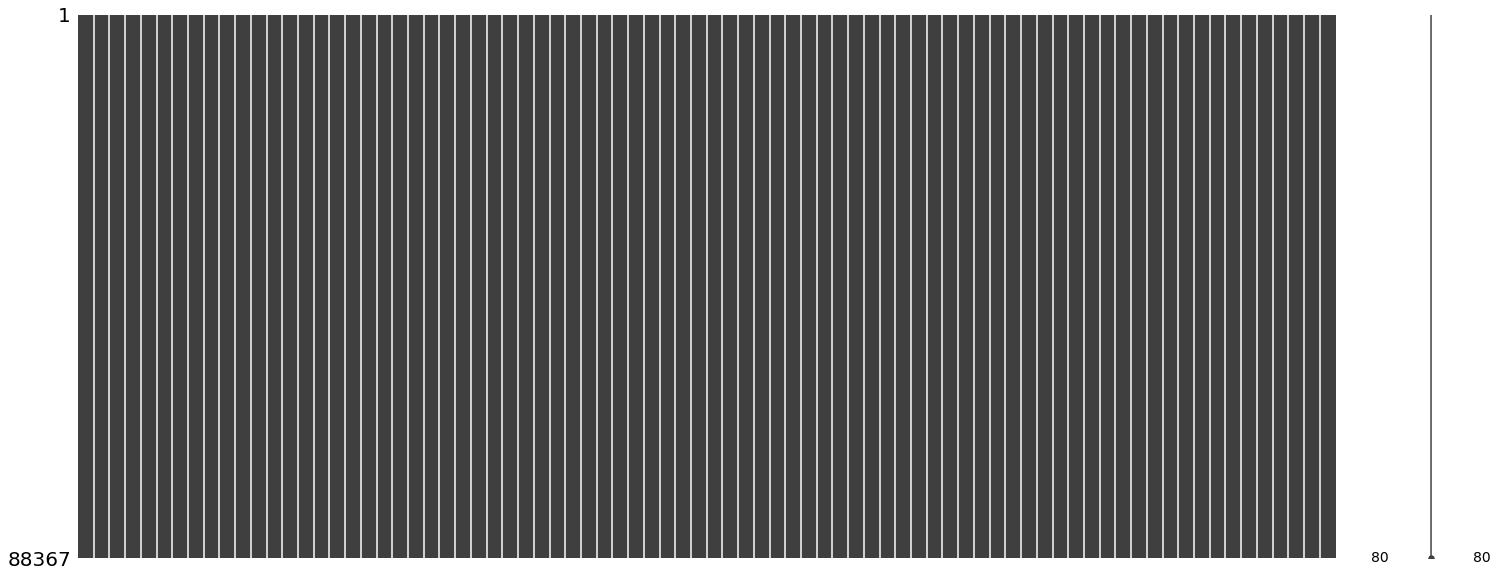

In [55]:
msno.matrix(training)

## Multicollinearity - remove columns that are highly correlated with each other

In [56]:
corr_matrix = training.corr().abs()

In [57]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

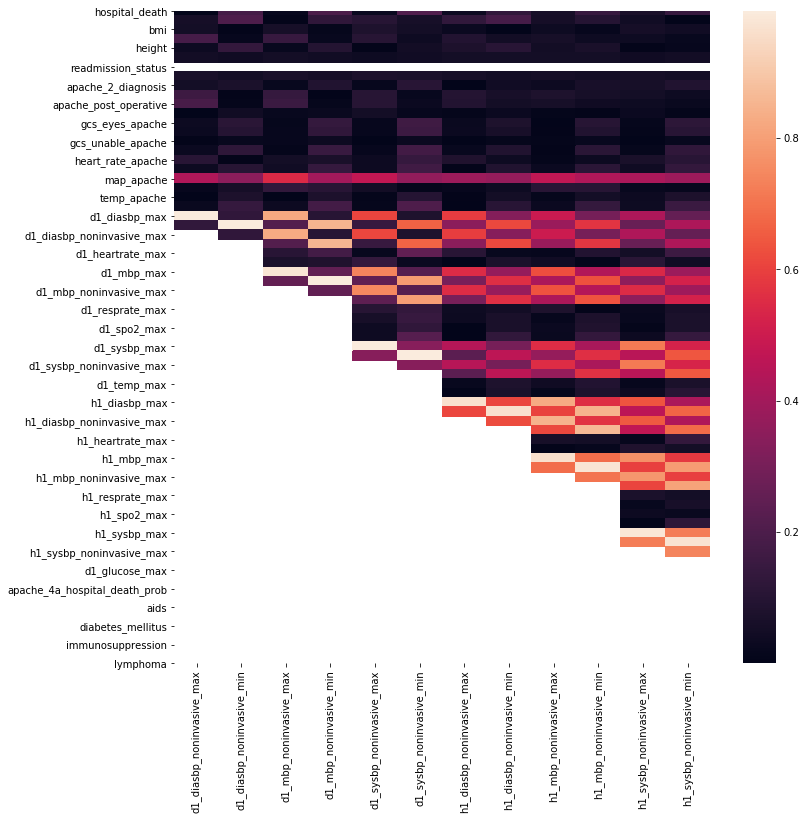

In [58]:
plt.figure(figsize=(12,12))

sns.heatmap(upper[to_drop])

In [59]:
# drop highly correlated features #revisit

# training.drop(columns=to_drop, inplace=True)

## Convert to numerical via labelencoding or onehotencoding #revisit

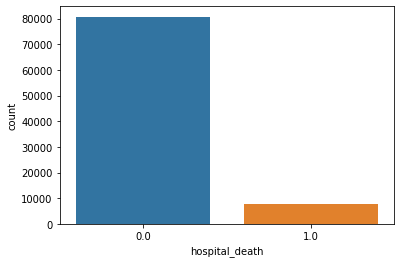

In [60]:
sns.countplot(training.hospital_death)

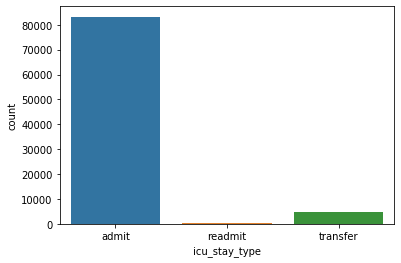

In [61]:
sns.countplot(categorical.icu_stay_type)

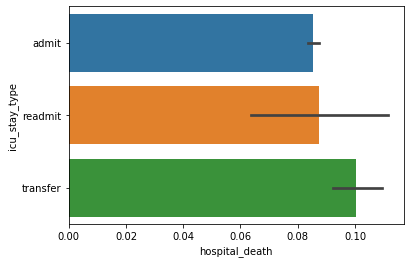

In [62]:
sns.barplot(training.hospital_death, categorical.icu_stay_type)

In [63]:
training_backup = training.copy()

In [31]:
training = training_backup.copy()

## train test split

In [13]:
# load train test split

from sklearn.model_selection import train_test_split

In [14]:
def drop_id_fields(df):
    id_columns_to_drop = df.filter(regex='id$',axis=1).columns
    df.drop(columns=id_columns_to_drop, inplace=True)
    return df

In [44]:
training = drop_id_fields(training)

In [16]:
training.head()

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,admit,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,admit,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,0,25.0,31.95,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,admit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,0,81.0,22.64,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,admit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,0,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,admit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [17]:
X = training.drop(columns=['hospital_death'])

In [18]:
y = training['hospital_death']

In [19]:
# convert to categorical features

X = pd.concat([
        X.select_dtypes([], ['object']),
        X.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(X.columns, axis=1)

In [112]:
X.head()

,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,admit,CTICU,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,admit,Med-Surg ICU,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,25.0,31.95,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,81.0,22.64,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,admit,CTICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,admit,Med-Surg ICU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [113]:
X.dtypes.value_counts().sum()

181

In [20]:
training = training_backup.copy()

## Train Test Split

In [21]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [22]:
# save the column list for later use

X_train_columns = X_train.columns.tolist()

In [23]:
Y_train, Y_test = y_train, y_test

In [24]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(73370, 181)
(18343, 181)
(73370,)
(18343,)


## Create Pipeline

In [25]:
# need to undo the previous preprocessing steps

# X_train.dtypes.value_counts()

In [26]:
## create transformers for pipeline

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## data needs to be at preprocessing stage
# need to undo steps below

# Standardise numerical fields
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                      ('scaler', StandardScaler())])

# Missing value imputer. Replace NaN with 'missing_value' for categorical fields.
categorical_transformer  = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                                           ('encoder', OneHotEncoder(handle_unknown='ignore'))])


In [27]:
# create a list of features with specific data types for processing

numeric_features     = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns


In [28]:
# Assemble categorical and numerical pipelines
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [29]:
preprocessor.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='mean',
                                                                verbose=0)),
                                                 ('scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                             

In [30]:
# https://stackoverflow.com/questions/10592605/save-classifier-to-disk-in-scikit-learn

from sklearn.externals import joblib

# now you can save it to a file
joblib.dump(preprocessor, 'preprocessor.pkl') 

# and later you can load it
preprocessor_load = joblib.load('preprocessor.pkl') 

C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [31]:
# before shape

X_train.shape

(73370, 181)

In [32]:
preprocessor.transform(X_train).shape

(73370, 239)

In [33]:
X_train_processed = preprocessor.transform(X_train)

In [34]:
# new cat features post pipeline (one hot encoding)

new_cat_features = preprocessor.named_transformers_.cat[1].get_feature_names().tolist()

In [35]:
post_pipeline_features = numeric_features.tolist() + new_cat_features

In [36]:
X_train_processed_df = pd.DataFrame(X_train_processed, columns=post_pipeline_features)

In [37]:
X_train_processed_df

,age,bmi,elective_surgery,height,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,...,x7_Gastrointestinal,x7_Haematologic,x7_Metabolic,x7_Neurologic,x7_Renal/Genitourinary,x7_Respiratory,x7_Trauma,x7_Undefined Diagnoses,x7_Undefined diagnoses,x7_missing_value
0,1.448557,-0.127551,-0.474986,0.050362,-0.335674,0.0,-0.101486,-2.038076e-15,1.355157,-3.281421e-01,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.593911,0.914818,-0.474986,0.041041,-0.300049,0.0,0.888962,-2.038076e-15,-0.720419,-5.515740e-01,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.603749,-0.214881,-0.474986,-0.658038,-0.317862,0.0,-0.466815,-2.038076e-15,-0.743872,3.117437e-01,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.138642,-0.889879,-0.474986,1.057036,-0.250229,0.0,-0.491170,-2.038076e-15,1.402062,7.412118e-01,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-2.153164,-1.138231,-0.474986,0.758762,-0.314800,0.0,-0.852440,-9.244760e-01,-0.849410,-1.263788e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73365,-2.824671,-0.840459,2.105327,-0.425012,-0.334004,0.0,-0.937683,-2.038076e-15,0.393591,2.049159e+00,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
73366,0.471819,0.033288,2.105327,0.963825,-0.111068,0.0,0.462745,-2.038076e-15,0.000000,-1.212608e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
73367,0.593911,0.199749,2.105327,1.616299,-0.240766,0.0,0.962028,-2.038076e-15,0.194242,1.400554e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73368,-0.993288,3.956434,-0.474986,-0.191985,-0.335674,0.0,3.580219,1.140727e+00,-0.978400,-7.663080e-01,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [38]:
X_train = X_train_processed

In [39]:
unlabeled = drop_id_fields(unlabeled)

In [45]:
unlabeled_processed = preprocessor.transform(unlabeled)

In [46]:
np.shape(unlabeled_processed)

(39308, 239)

In [89]:
# clf = Pipeline([
#     ('transform', preprocessor),
#     ('LGBM', lgb.LGBMClassifier())
# ])

## Model

In [47]:
# Cross validate model with Kfold stratified cross val
kfold = 10
n_jobs = 5
random_state = 42
kf = 10

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
import xgboost as xgb
import lightgbm as lgb

sns.set(style='white', context='notebook', palette='deep')

In [49]:
# Cross validate model with Kfold stratified cross val

kfold = StratifiedKFold(n_splits=10)
random_state = 42

# adjust this
n_jobs = 8 # -1


In [53]:
#Model building
d_train = lgb.Dataset(X_train, label=y_train)
# params = {}
# params['learning_rate'] = 0.003
# params['boosting_type'] = 'gbdt'
# params['objective'] = 'binary'
# params['metric'] = 'binary_logloss'
# params['sub_feature'] = 0.5
# params['num_leaves'] = 100
# params['min_data'] = 50
# params['max_depth'] = 10


In [58]:
params = {'num_leaves': 31, 'objective': 'binary'}

In [59]:
params['metric'] = 'auc'

In [60]:
clf = lgb.train(params, d_train, 100)

#Prediction
y_pred=clf.predict(X_test)
y_pred1=np.round(y_pred)

#Measure accuracy
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred1)
print (cm)
#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred1,y_test)
print (accuracy)

#Prediction on Test variables
pred_on_test=clf.predict(unlabeled_processed)

pd.DataFrame(pred_on_test).sort_values(by=[0], ascending=False)

solution_template.hospital_death = pred_on_test
solution_template.to_csv("submissionlgbm.csv", index=0)

[[ 1717 15039]
 [  147  1440]]
0.17210925148558032


In [100]:
# Modeling step Test differents algorithms 
classifiers = []
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(lgb.LGBMClassifier(random_state=random_state))
classifiers.append(xgb.XGBClassifier(random_state=random_state))
# classifiers.append(SVC(random_state=random_state))
# classifiers.append(DecisionTreeClassifier(random_state=random_state))
# classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
# classifiers.append(ExtraTreesClassifier(random_state=random_state))
# classifiers.append(GradientBoostingClassifier(random_state=random_state))
# classifiers.append(MLPClassifier(random_state=random_state))
# classifiers.append(KNeighborsClassifier())
# classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "roc_auc", cv = kfold, n_jobs=n_jobs, verbose=1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:   17.0s remaining:   11.3s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   24.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    3.0s remaining:    2.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    4.3s remaining:    2.8s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    7.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:   57.3s remaining:   38.2s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.6min finished


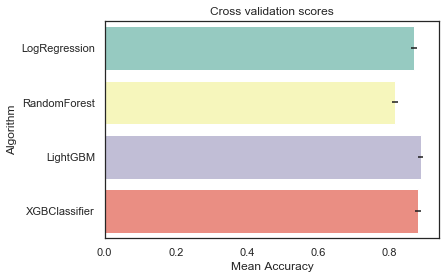

In [101]:
# cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["LogRegression", "SVC","DecisionTree","AdaBoost",
# "RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LinearDiscriminantAnalysis"]})

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["LogRegression", "RandomForest", "LightGBM", "XGBClassifier"]})


g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
# g.set_xlabel("Mean Accuracy")
# g = g.set_title("Cross validation scores")
    
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [124]:
cv_res.sort_values('CrossValMeans', ascending=False)

,CrossValMeans,CrossValerrors,Algorithm
2,0.889020,0.007322,LightGBM
3,0.879896,0.008413,XGBClassifier
0,0.870104,0.007850,LogRegression
1,0.816774,0.008890,RandomForest


In [119]:
lgb.LGBMClassifier?

Init signature:
lgb.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    subsample_for_bin=200000,
    objective=None,
    class_weight=None,
    min_split_gain=0.0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=None,
    n_jobs=-1,
    silent=True,
    importance_type='split',
    **kwargs,
)
Docstring:      LightGBM classifier.
Init docstring:
Construct a gradient boosting model.

Parameters
----------
boosting_type : string, optional (default='gbdt')
    'gbdt', traditional Gradient Boosting Decision Tree.
    'dart', Dropouts meet Multiple Additive Regression Trees.
    'goss', Gradient-based One-Side Sampling.
    'rf', Random Forest.
num_leaves : int, optional (default=31)
    Maximum tree leaves for base learners.
max_depth : int, optional (default=-1)
    Maximum tree depth f

In [118]:
test

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [115]:
# try loading a saved model

try:
 
    gsLGBM = joblib.load('gsLGBM.pkl') 
    LGBM_best = joblib.load('gsLGBM.best_estimator_.pkl') 
    
    print('Successfully loaded existing saved models')
    
except:
    
    print('Unsuccessfully loaded existing saved models. Performing GridSearchCV')
    LGBM = lgb.LGBMClassifier()

    ## Search grid for optimal parameters
    LGBM_param_grid = {"max_depth": [None],
                  "max_features": [1, 3, 10],
                  "min_samples_split": [2, 3, 10],
                  "min_samples_leaf": [1, 3, 10],
                  "bootstrap": [False],
                  "n_estimators" :[100,300],
                  "criterion": ["gini"]
                      }

    # grid search using list of parameters
    gsLGBM = GridSearchCV(LGBM, param_grid=LGBM_param_grid, cv=kfold, scoring="roc_auc", n_jobs=, verbose=1)

    gsLGBM.fit(X_train, y_train)
    
        # save it to a file
    joblib.dump(gsLGBM, 'gsLGBM.pkl') 

    # and later you can load it
    # gsLGBM = joblib.load('gsLGBM.pkl') 

    joblib.dump(gsLGBM.best_estimator_, 'gsLGBM.best_estimator_.pkl') 

    # and later you can load it
    # LGBM_best = joblib.load('gsLGBM.best_estimator_.pkl') 


LGBM_best = gsLGBM.best_estimator_

# Best score
gsLGBM.best_score_

0.8988894411870775

In [128]:
try:
 
    gsRFC = joblib.load('gsRFC.pkl') 
    RFC_best = joblib.load('gsRFC.best_estimator_.pkl') 
    
    print('Successfully loaded existing saved models')
    
except:
    
    print('Unsuccessfully loaded existing saved models. Performing GridSearchCV')

    # RFC Parameters tunning 
    RFC = RandomForestClassifier()


    ## Search grid for optimal parameters
    rf_param_grid = {"max_depth": [None],
                  "max_features": [1, 3, 10],
                  "min_samples_split": [2, 3, 10],
                  "min_samples_leaf": [1, 3, 10],
                  "bootstrap": [False],
                  "n_estimators" :[100,300],
                  "criterion": ["gini"]}


    gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv=kfold, scoring="roc_auc", n_jobs=n_jobs, verbose = 1)

    gsRFC.fit(X_train,y_train)
    
            # save it to a file
    joblib.dump(gsRFC, 'gsRFC.pkl') 

    # and later you can load it
    # gsLGBM = joblib.load('gsLGBM.pkl') 

    joblib.dump(gsRFC.best_estimator_, 'gsRFC.best_estimator_.pkl') 

    # and later you can load it
    # LGBM_best = joblib.load('gsLGBM.best_estimator_.pkl') 

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Successfully loaded existing saved models


0.8945533181390115

In [129]:
try:
 
    gsXGBC = joblib.load('gsXGBC.pkl') 
    XGBC_best = joblib.load('gsXGBC.best_estimator_.pkl') 
    
    print('Successfully loaded existing saved models')
    
except:
    
    print('Unsuccessfully loaded existing saved models. Performing GridSearchCV')
    # XGBC Parameters tunning 

    XGBC = xgb.XGBClassifier()


    ## Search grid for optimal parameters
    XGBC_param_grid = {"max_depth": [None],
                  "max_features": [1, 3, 10],
                  "min_samples_split": [2, 3, 10],
                  "min_samples_leaf": [1, 3, 10],
                  "bootstrap": [False],
                  "n_estimators" :[100,300],
                  "criterion": ["gini"]}


    gsXGBC = GridSearchCV(XGBC, param_grid = XGBC_param_grid, cv=kfold, scoring="roc_auc", n_jobs=n_jobs, verbose = 1)

    gsXGBC.fit(X_train,y_train)
    
    # save it to a file
    joblib.dump(gsXGBC, 'gsXGBC.pkl') 

    # and later you can load it
    # gsLGBM = joblib.load('gsLGBM.pkl') 

    joblib.dump(gsXGBC.best_estimator_, 'gsXGBC.best_estimator_.pkl') 

    # and later you can load it
    # LGBM_best = joblib.load('gsLGBM.best_estimator_.pkl') 

    

XGBC_best = gsXGBC.best_estimator_

# Best score
gsXGBC.best_score_

Successfully loaded existing saved models


0.8920527842251131

Wall time: 0 ns


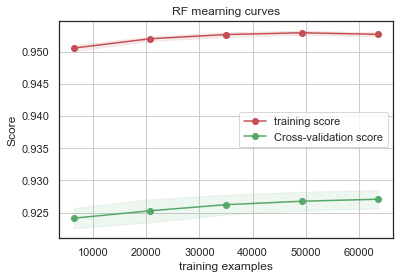

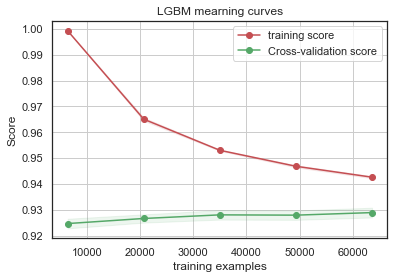

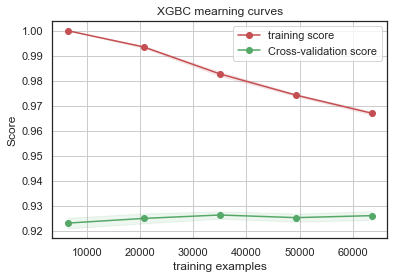

In [130]:
%time

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,y_train,cv=kfold)
# g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=kfold)
# g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,y_train,cv=kfold)
# g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,y_train,cv=kfold)
# g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsLGBM.best_estimator_, "LGBM mearning curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(gsXGBC.best_estimator_,"XGBC mearning curves",X_train,y_train,cv=kfold)


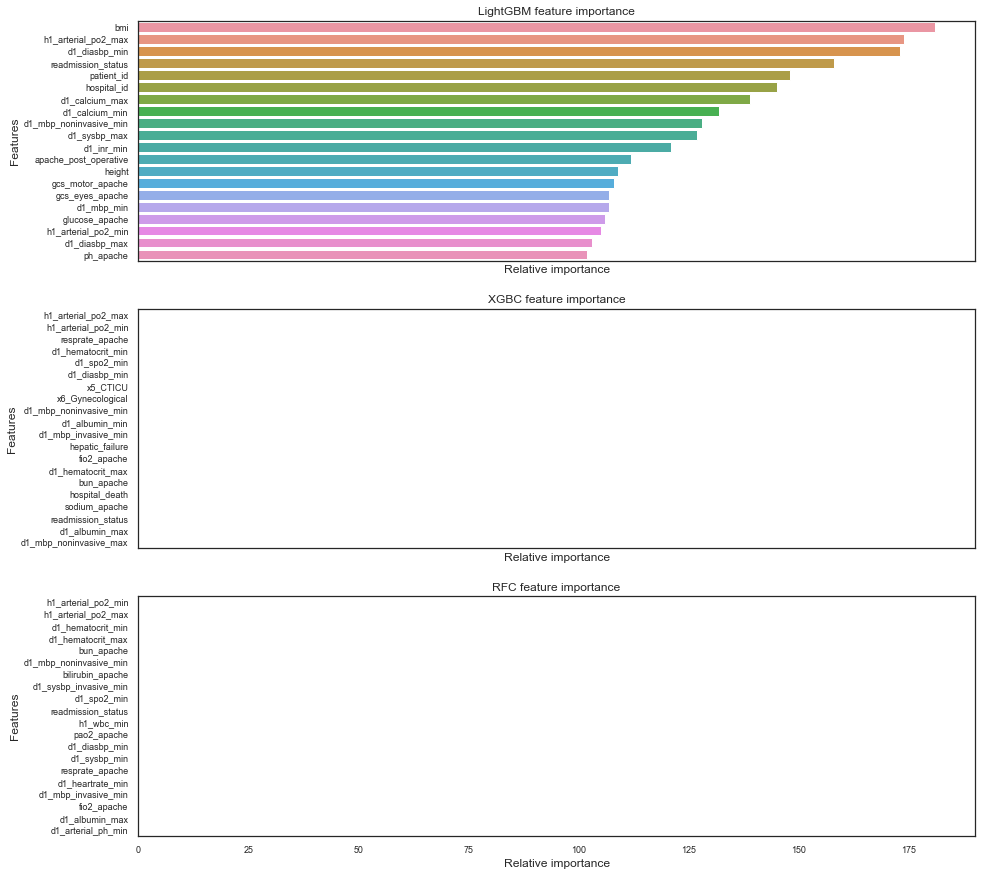

In [230]:
# nrows = 1
# ncols = 1

nrows = 3
ncols = 1

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

# names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]
# names_classifiers = [("RandomForest", RFC_best), ("LightGBM", LGBM_best)]
names_classifiers = [("LightGBM", LGBM_best), ('XGBC', XGBC_best), ('RFC', RFC_best)]

nclassifier = 0

for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:20]
        g = sns.barplot(y=X_train_processed_df.columns[indices][:20],x = classifier.feature_importances_[indices][:20] , orient='h', ax=axes[row])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1
        
        

In [244]:
names_classifiers

[('LightGBM',
  LGBMClassifier(boosting_type='gbdt', bootstrap=False, class_weight=None,
                 colsample_bytree=1.0, criterion='gini', importance_type='split',
                 learning_rate=0.1, max_depth=None, max_features=1,
                 min_child_samples=20, min_child_weight=0.001, min_samples_leaf=1,
                 min_samples_split=2, min_split_gain=0.0, n_estimators=300,
                 n_jobs=-1, num_leaves=31, objective=None, random_state=None,
                 reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                 subsample_for_bin=200000, subsample_freq=0)),
 ('XGBC', XGBClassifier(base_score=0.5, booster=None, bootstrap=False,
                colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
                criterion='gini', gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints=None, learning_rate=0.300000012,
                max_delta_step=0, max_depth=6, max_features=1, min_child_weight=1,
   

In [245]:
names_classifiers[0][0]

'LightGBM'

In [246]:
names_classifiers[0][1]

LGBMClassifier(boosting_type='gbdt', bootstrap=False, class_weight=None,
               colsample_bytree=1.0, criterion='gini', importance_type='split',
               learning_rate=0.1, max_depth=None, max_features=1,
               min_child_samples=20, min_child_weight=0.001, min_samples_leaf=1,
               min_samples_split=2, min_split_gain=0.0, n_estimators=300,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [250]:
dict(zip(X_train_processed_df.columns[indices][:20], classifier.feature_importances_[indices][:20]))

{'h1_arterial_po2_min': 0.07505967549358876,
 'h1_arterial_po2_max': 0.07008449869681387,
 'd1_hematocrit_min': 0.030816859528730475,
 'd1_hematocrit_max': 0.027428221134468335,
 'bun_apache': 0.022460782674898223,
 'd1_mbp_noninvasive_min': 0.019712549505569294,
 'bilirubin_apache': 0.018740552985921064,
 'd1_sysbp_invasive_min': 0.017894870974565342,
 'd1_spo2_min': 0.017679203229365954,
 'readmission_status': 0.01655731254854479,
 'h1_wbc_min': 0.01620363345897105,
 'pao2_apache': 0.01350435838374734,
 'd1_diasbp_min': 0.013293965407837663,
 'd1_sysbp_min': 0.013045940960398806,
 'resprate_apache': 0.012896195450278357,
 'd1_heartrate_min': 0.012420002748961932,
 'd1_mbp_invasive_min': 0.011795277547328257,
 'fio2_apache': 0.011548993266437012,
 'd1_albumin_max': 0.011343384314490574,
 'd1_arterial_ph_min': 0.011033268269072699}

In [259]:
X_train_processed_df.columns[indices][:20].tolist()

['h1_arterial_po2_min',
 'h1_arterial_po2_max',
 'd1_hematocrit_min',
 'd1_hematocrit_max',
 'bun_apache',
 'd1_mbp_noninvasive_min',
 'bilirubin_apache',
 'd1_sysbp_invasive_min',
 'd1_spo2_min',
 'readmission_status',
 'h1_wbc_min',
 'pao2_apache',
 'd1_diasbp_min',
 'd1_sysbp_min',
 'resprate_apache',
 'd1_heartrate_min',
 'd1_mbp_invasive_min',
 'fio2_apache',
 'd1_albumin_max',
 'd1_arterial_ph_min']

In [339]:
# test pull requests
data = { 'features': X_train_processed_df.columns[indices][:20].tolist(), 'importance': classifier.feature_importances_[indices][:20].tolist() } 

In [340]:
# test pull requests

data_x = pd.DataFrame.from_dict(data).sort_values('importance', ascending=False)

In [341]:
# test pull requests

data_x.head()

,features,importance
0,apache_4a_icu_death_prob,0.075060
1,apache_4a_hospital_death_prob,0.070084
2,d1_lactate_min,0.030817
3,d1_lactate_max,0.027428
4,gcs_motor_apache,0.022461


In [342]:
# test pull requests

indices = np.argsort(classifier.feature_importances_)[::-1][:20]

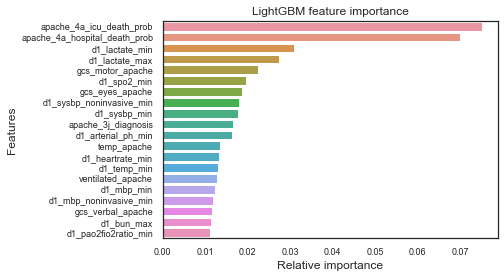

In [343]:
# test pull requests

name = names_classifiers[0][0]
classifier = names_classifiers[0][1]
indices = np.argsort(classifier.feature_importances_)[::-1][:20]
g = sns.barplot(y=data_x['features'], x = data_x['importance'] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title(name + " feature importance")
nclassifier += 1

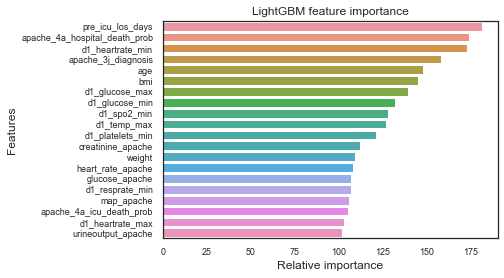

In [344]:
# test pull requests

name = names_classifiers[0][0]
classifier = names_classifiers[0][1]
indices = np.argsort(classifier.feature_importances_)[::-1][:20]
g = sns.barplot(y=X_train_processed_df.columns[indices][:20], x = classifier.feature_importances_[indices][:20] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title(name + " feature importance")
nclassifier += 1

In [325]:
# test pull requests

classifier

LGBMClassifier(boosting_type='gbdt', bootstrap=False, class_weight=None,
               colsample_bytree=1.0, criterion='gini', importance_type='split',
               learning_rate=0.1, max_depth=None, max_features=1,
               min_child_samples=20, min_child_weight=0.001, min_samples_leaf=1,
               min_samples_split=2, min_split_gain=0.0, n_estimators=300,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [326]:
indices

array([  4, 163,  42,   9,   0,   1,  97,  98,  52,  59, 110,  14,   6,
        21,  20,  50,  24, 164,  41,  32], dtype=int64)

In [327]:
X_train_processed_df.columns[indices][:20]

Index(['pre_icu_los_days', 'apache_4a_hospital_death_prob', 'd1_heartrate_min',
       'apache_3j_diagnosis', 'age', 'bmi', 'd1_glucose_max', 'd1_glucose_min',
       'd1_spo2_min', 'd1_temp_max', 'd1_platelets_min', 'creatinine_apache',
       'weight', 'heart_rate_apache', 'glucose_apache', 'd1_resprate_min',
       'map_apache', 'apache_4a_icu_death_prob', 'd1_heartrate_max',
       'urineoutput_apache'],
      dtype='object')

In [322]:
classifier.feature_importances_[indices][:20]

array([181, 174, 173, 158, 148, 145, 139, 132, 128, 127, 121, 112, 109,
       108, 107, 107, 106, 105, 103, 102])

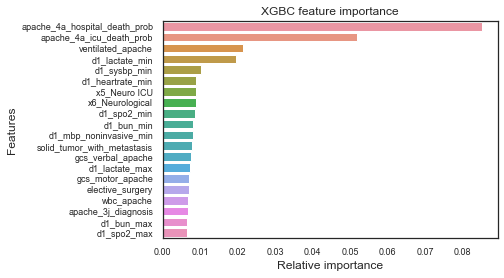

In [330]:
name = names_classifiers[1][0]
classifier = names_classifiers[1][1]
indices = np.argsort(classifier.feature_importances_)[::-1][:20]
g = sns.barplot(y=X_train_processed_df.columns[indices][:20],x = classifier.feature_importances_[indices][:20] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title(name + " feature importance")
nclassifier += 1

In [331]:
classifier

XGBClassifier(base_score=0.5, booster=None, bootstrap=False,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              criterion='gini', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, max_features=1, min_child_weight=1,
              min_samples_leaf=1, min_samples_split=2, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, ...)

In [282]:
indices

array([163, 164,  33, 108,  56,  42, 214, 223,  52,  92,  48, 172,  19,
       107,  17,   2,  34,   9,  91,  51], dtype=int64)

In [335]:
X_train_processed_df.columns[indices][:20].tolist()

['apache_4a_icu_death_prob',
 'apache_4a_hospital_death_prob',
 'd1_lactate_min',
 'd1_lactate_max',
 'gcs_motor_apache',
 'd1_spo2_min',
 'gcs_eyes_apache',
 'd1_sysbp_noninvasive_min',
 'd1_sysbp_min',
 'apache_3j_diagnosis',
 'd1_arterial_ph_min',
 'temp_apache',
 'd1_heartrate_min',
 'd1_temp_min',
 'ventilated_apache',
 'd1_mbp_min',
 'd1_mbp_noninvasive_min',
 'gcs_verbal_apache',
 'd1_bun_max',
 'd1_pao2fio2ratio_min']

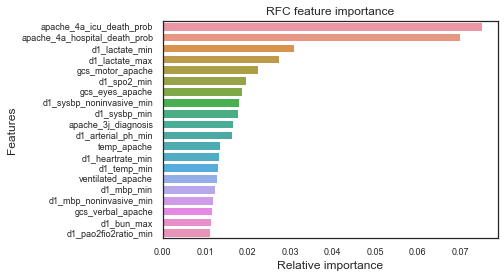

In [332]:
name = names_classifiers[2][0]
classifier = names_classifiers[2][1]
indices = np.argsort(classifier.feature_importances_)[::-1][:20]
g = sns.barplot(y=X_train_processed_df.columns[indices][:20],x = classifier.feature_importances_[indices][:20] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title(name + " feature importance")
nclassifier += 1

In [333]:
classifier

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [279]:
indices

array([164, 163, 108, 107,  17,  52,  16,  58,  56,   9, 150,  31,  42,
        60,  33,  46,  48,  19,  91, 154], dtype=int64)

In [337]:
X_train_processed_df.columns[indices][:20].tolist()

['apache_4a_icu_death_prob',
 'apache_4a_hospital_death_prob',
 'd1_lactate_min',
 'd1_lactate_max',
 'gcs_motor_apache',
 'd1_spo2_min',
 'gcs_eyes_apache',
 'd1_sysbp_noninvasive_min',
 'd1_sysbp_min',
 'apache_3j_diagnosis',
 'd1_arterial_ph_min',
 'temp_apache',
 'd1_heartrate_min',
 'd1_temp_min',
 'ventilated_apache',
 'd1_mbp_min',
 'd1_mbp_noninvasive_min',
 'gcs_verbal_apache',
 'd1_bun_max',
 'd1_pao2fio2ratio_min']

In [354]:
# store column indices with

indices1 = np.argsort(names_classifiers[0][1].feature_importances_)[::-1][:25]
indices2 = np.argsort(names_classifiers[1][1].feature_importances_)[::-1][:25]
indices3 = np.argsort(names_classifiers[2][1].feature_importances_)[::-1][:25]

In [355]:
np.concatenate([indices1, indices2, indices3])

array([  4, 163,  42,   9,   0,   1,  97,  98,  52,  59, 110,  14,   6,
        21,  20,  50,  24, 164,  41,  32, 113,  68,  49,  60,  55, 163,
       164,  33, 108,  56,  42, 214, 223,  52,  92,  48, 172,  19, 107,
        17,   2,  34,   9,  91,  51, 110, 218,  41, 149,  40, 164, 163,
       108, 107,  17,  52,  16,  58,  56,   9, 150,  31,  42,  60,  33,
        46,  48,  19,  91, 154,  92,  59,  95,  28, 149], dtype=int64)

In [356]:
len(np.unique([indices1, indices2, indices3]).tolist())

51

In [366]:
important_features_indices = np.unique([indices1, indices2, indices3])

In [367]:
important_features_indices

array([  0,   1,   2,   4,   6,   9,  14,  16,  17,  19,  20,  21,  24,
        28,  31,  32,  33,  34,  40,  41,  42,  46,  48,  49,  50,  51,
        52,  55,  56,  58,  59,  60,  68,  91,  92,  95,  97,  98, 107,
       108, 110, 113, 149, 150, 154, 163, 164, 172, 214, 218, 223],
      dtype=int64)

In [362]:
# list of features determined from feature importance - 51 features

important_features_list = X_train_processed_df.columns[np.unique([indices1, indices2, indices3]).tolist()]

In [363]:
important_features_list

Index(['age', 'bmi', 'elective_surgery', 'pre_icu_los_days', 'weight',
       'apache_3j_diagnosis', 'creatinine_apache', 'gcs_eyes_apache',
       'gcs_motor_apache', 'gcs_verbal_apache', 'glucose_apache',
       'heart_rate_apache', 'map_apache', 'ph_apache', 'temp_apache',
       'urineoutput_apache', 'ventilated_apache', 'wbc_apache',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min',
       'd1_mbp_min', 'd1_mbp_noninvasive_min', 'd1_resprate_max',
       'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max',
       'd1_sysbp_min', 'd1_sysbp_noninvasive_min', 'd1_temp_max',
       'd1_temp_min', 'h1_heartrate_min', 'd1_bun_max', 'd1_bun_min',
       'd1_creatinine_max', 'd1_glucose_max', 'd1_glucose_min',
       'd1_lactate_max', 'd1_lactate_min', 'd1_platelets_min', 'd1_sodium_max',
       'd1_arterial_ph_max', 'd1_arterial_ph_min', 'd1_pao2fio2ratio_min',
       'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob',
       'solid_tumor_wi

In [ ]:
# test on LGBC


important_features_indices

In [373]:
X_train[:, important_features_indices]

array([[ 1.44855654, -0.1275513 , -0.47498567, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.59391098,  0.91481754, -0.47498567, ...,  0.        ,
         0.        ,  0.        ],
       [-1.60374903, -0.21488097, -0.47498567, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.59391098,  0.19974877,  2.10532668, ...,  0.        ,
         0.        ,  0.        ],
       [-0.99328791,  3.95643426, -0.47498567, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.92738564, -0.47498567, ...,  0.        ,
         0.        ,  0.        ]])

In [375]:
#
LGBM = lgb.LGBMClassifier()

    ## Search grid for optimal parameters
#     LGBM_param_grid = {"max_depth": [None],
#                   "max_features": [1, 3, 10],
#                   "min_samples_split": [2, 3, 10],
#                   "min_samples_leaf": [1, 3, 10],
#                   "bootstrap": [False],
#                   "n_estimators" :[100,300],
#                   "criterion": ["gini"]
#                       }

LGBM_param_grid = { "max_features": [1, 3, 10] }

# grid search using list of parameters
gsLGBM = GridSearchCV(LGBM, param_grid=LGBM_param_grid, cv=kfold, scoring="roc_auc", n_jobs=-1, verbose=1)

gsLGBM.fit(X_train[:, important_features_indices], y_train)
    
        # save it to a file
#     joblib.dump(gsLGBM, 'gsLGBM.pkl') 

    # and later you can load it
    # gsLGBM = joblib.load('gsLGBM.pkl') 

#     joblib.dump(gsLGBM.best_estimator_, 'gsLGBM.best_estimator_.pkl') 

    # and later you can load it
    # LGBM_best = joblib.load('gsLGBM.best_estimator_.pkl') 


LGBM_best = gsLGBM.best_estimator_

# Best score
gsLGBM.best_score_

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.4s finished


0.8978474949100871

In [234]:
# Need to align test set with train

apply all preprocesing steps to test data frame

drop id fields
drop missing columns
drop missing rows
fill nas / impute missing values
- categorical, mode
- numerical, mean
multicollinearity threshold > 0.95
one hot encode categorical fields
scale all day except for target label



In [238]:
training

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.730000,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.420000,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.950000,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.640000,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,0,75.0,23.060250,0,Caucasian,M,177.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,66119,13486,121,0,56.0,47.179671,0,Caucasian,F,183.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,8981,58179,195,0,48.0,27.236914,0,Caucasian,M,170.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,33776,120598,66,0,NaN,23.297481,0,Caucasian,F,154.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


In [239]:
training.select_dtypes('object').melt().groupby(['variable', 'value']).size()

variable               value                    
apache_2_bodysystem    Cardiovascular               38816
                       Gastrointestinal              9026
                       Haematologic                   638
                       Metabolic                     7650
                       Neurologic                   11896
                       Renal/Genitourinary           2460
                       Respiratory                  11609
                       Trauma                        3842
                       Undefined Diagnoses            346
                       Undefined diagnoses           3768
apache_3j_bodysystem   Cardiovascular               29999
                       Gastrointestinal              9026
                       Genitourinary                 2172
                       Gynecological                  313
                       Hematological                  638
                       Metabolic                     7650
                       

In [240]:
unlabeled.select_dtypes('object').melt().groupby(['variable', 'value']).size()

variable               value                    
apache_2_bodysystem    Cardiovascular               14829
                       Gastrointestinal              3949
                       Haematologic                   192
                       Metabolic                     3101
                       Neurologic                    5989
                       Renal/Genitourinary            932
                       Respiratory                   5284
                       Trauma                        2395
                       Undefined Diagnoses            141
                       Undefined diagnoses           1600
apache_3j_bodysystem   Cardiovascular               11393
                       Gastrointestinal              3949
                       Genitourinary                  820
                       Gynecological                  124
                       Hematological                  192
                       Metabolic                     3101
                       

In [61]:
test = preprocessor.transform(unlabeled)

In [379]:
test = test[:, important_features_indices]

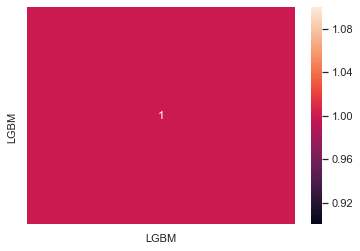

In [380]:
# test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
# test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
# test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
# test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")
test_Survived_LGBM = pd.Series(LGBM_best.predict(test), name="LGBM")
# test_Survived_XGBC = pd.Series(XGBC_best.predict(test), name="XGBC")
# test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")


# Concatenate all classifier results
# ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)

# ensemble_results = pd.concat([test_Survived_RFC, test_Survived_LGBM, test_Survived_XGBC],axis=1)
ensemble_results = pd.concat([test_Survived_LGBM],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [381]:
# votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
# ('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = VotingClassifier(estimators=[('lgbmc', LGBM_best)],  voting='soft', n_jobs=-1)
# votingC = VotingClassifier(estimators=[('lgbmc', LGBM_best),('rfc', RFC_best),('xgbc', XGBC_best)],  voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, y_train)

In [384]:
# votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
# ('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = VotingClassifier(estimators=[('lgbmc', LGBM_best)],  voting='soft', n_jobs=-1)
# votingC = VotingClassifier(estimators=[('lgbmc', LGBM_best),('rfc', RFC_best),('xgbc', XGBC_best)],  voting='soft', n_jobs=4)

votingC = votingC.fit(X_train[:, important_features_indices], y_train)

In [385]:
test_Survived = pd.Series(votingC.predict(test), name="hospital_death")

results = pd.concat([unlabeled['encounter_id'], test_Survived],axis=1)

results.to_csv("ensemble_python_voting1.csv", index=False)

In [386]:
end_time = datetime.now()

In [387]:
print(end_time - start_time)

1 day, 1:26:30.914538
